In [1]:
import numpy as np
import pandas as pd
import random
from collections import deque
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.distributions import Normal
from torch.utils.data import TensorDataset, DataLoader, Dataset

import gymnasium as gym

import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
from datetime import datetime
import os
import cv2

In [2]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

### Model

In [3]:
class Actor(nn.Module): # action return
    def __init__(self):
        super(Actor, self).__init__()
        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(500, 512) # state_dim = 500
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 64)
        self.mu_layer = nn.Linear(64, 1) # action_dim = 1
        self.log_std_layer = nn.Linear(64, 1) # action_dim = 1

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))

        mu = self.mu_layer(x)
        log_std = torch.tanh(self.log_std_layer(x)) # -1에서 1 사이로 표준편차의 로그값 반환

        return mu, log_std.exp()

class Critic(nn.Module): # value return
    def __init__(self):
        super(Critic, self).__init__()
        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(500, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 64)
        self.layer4 = nn.Linear(64, 1)
    
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.layer4(x)

        return x

### Utils

In [4]:
class RolloutBuffer:
    def __init__(self):
        self.buffer = list()

    def store(self, transition):
        self.buffer.append(transition)

    def sample(self):
        s, a, r, s_prime, done = map(np.array, zip(*self.buffer))
        self.buffer.clear()
        return (
            torch.FloatTensor(s),
            torch.FloatTensor(a),
            torch.FloatTensor(r).unsqueeze(1),
            torch.FloatTensor(s_prime),
            torch.FloatTensor(done).unsqueeze(1)
        )

    @property
    def size(self):
        return len(self.buffer)

class TradingGraph:
    # A crypto trading visualization using matplotlib made to render custom prices which come in following way:
    # Date, Open, High, Low, Close, Volume, net_worth, trades
    # call render every step
    def __init__(self, render_range):
        self.volume = deque(maxlen=render_range)
        self.net_worth = deque(maxlen=render_range)
        self.render_data = deque(maxlen=render_range)
        self.render_range = render_range

        # We are using the style ‘ggplot’
        plt.style.use('ggplot')
        # close all plots if there are open
        plt.close('all')
        # figsize attribute allows us to specify the width and height of a figure in unit inches
        self.fig = plt.figure(figsize=(16,8)) 

        # Create top subplot for price axis
        self.ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
        
        # Create bottom subplot for volume which shares its x-axis
        self.ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=self.ax1)
        
        # Create a new axis for net worth which shares its x-axis with price
        self.ax3 = self.ax1.twinx()

        # Formatting Date
        self.date_format = mpl_dates.DateFormatter('%d-%m-%Y')
        
        # Add paddings to make graph easier to view
        #plt.subplots_adjust(left=0.07, bottom=-0.1, right=0.93, top=0.97, wspace=0, hspace=0)

    # Render the environment to the screen
    def render(self, date, open, high, low, close, volume, net_worth, trades):
        # append volume and net_worth to deque list
        self.volume.append(volume)
        self.net_worth.append(net_worth)

        # before appending to deque list, need to convert Date to special format
        date = mpl_dates.date2num([pd.to_datetime(date)])[0]
        self.render_data.append([date, open, high, low, close])
        
        # Clear the frame rendered last step
        self.ax1.clear()
        candlestick_ohlc(self.ax1, self.render_data, width=0.8/24, colorup='red', colordown='blue', alpha=0.8)

        # Put all dates to one list and fill ax2 sublot with volume
        date_render_range = [i[0] for i in self.render_data]
        self.ax2.clear()
        self.ax2.fill_between(date_render_range, self.volume, 0)

        # draw our net_worth graph on ax3 (shared with ax1) subplot
        self.ax3.clear()
        self.ax3.plot(date_render_range, self.net_worth, color="blue")
        
        # beautify the x-labels (Our Date format)
        self.ax1.xaxis.set_major_formatter(self.date_format)
        self.fig.autofmt_xdate()

        # sort sell and buy orders, put arrows in appropiate order positions
        for trade in trades:
            trade_date = mpl_dates.date2num([pd.to_datetime(trade['Date'])])[0]
            if trade_date in date_render_range:
                if trade['Type'] == 'buy':
                    high_low = trade['Low']-10
                    self.ax1.scatter(trade_date, high_low, c='red', label='red', s = 120, edgecolors='none', marker="^")
                else:
                    high_low = trade['High']+10
                    self.ax1.scatter(trade_date, high_low, c='blue', label='blue', s = 120, edgecolors='none', marker="v")

        # we need to set layers every step, because we are clearing subplots every step
        self.ax2.set_xlabel('Date')
        self.ax1.set_ylabel('Price')
        self.ax3.yaxis.set_label_position('right')
        self.ax3.set_ylabel('Balance') # 여기 수정

        # I use tight_layout to replace plt.subplots_adjust
        self.fig.tight_layout()

        """Display image with matplotlib - interrupting other tasks"""
        # Show the graph without blocking the rest of the program
        plt.show(block=False)
        # Necessary to view frames before they are unrendered
        plt.pause(0.001)
        

### Env

In [66]:
class TradingEnv:
    def __init__(self, df, initial_balance=1000, lookback_window_size=50, render_range=100):
        self.df = df.dropna().reset_index()
        self.df_total_steps = len(self.df) - 1 # 따라서 trading 데이터를 df에 넣어줘야 한다
        self.initial_balance = initial_balance
        self.lookback_window_size = lookback_window_size
        self.render_range = render_range

        self.buffer = RolloutBuffer()

        # Neural networks part bellow
        self.lr = 0.0001
        self.epochs = 1
        self.normalise_value = 100000       
        self.batch_size = 64 
        self.gamma = 0.99
        self.n_epochs = 10
        self.lmbda = 0.5
        self.clip_ratio = 0.2

        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(1,))
        self.state_size = (self.lookback_window_size, 10)

        self.orders_history = deque(maxlen=self.lookback_window_size)
        self.market_history = deque(maxlen=self.lookback_window_size)

        # Create actor-critic network model
        self.Actor = Actor().to(device)
        self.Critic = Critic().to(device)

        self.actor_optimizer = optim.Adam(self.Actor.parameters(), lr=self.lr)
        self.critic_optimizer = optim.Adam(self.Critic.parameters(), lr=self.lr)

    def reset(self, env_steps_size = 0):
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.prev_net_worth = self.initial_balance
        self.crypto_held = 0
        self.crypto_sold = 0
        self.crypto_bought = 0
        
        self.visualisation = TradingGraph(render_range=self.render_range)
        self.trades = deque(maxlen=self.render_range)

        self.env_steps_size = env_steps_size

        if env_steps_size > 0: # used for training dataset
            self.start_step = random.randint(self.lookback_window_size, self.df_total_steps - env_steps_size)
            self.end_step = self.start_step + env_steps_size
        else: # used for testing dataset
            self.start_step = self.lookback_window_size
            self.end_step = self.df_total_steps

        self.current_step = self.start_step

        # 50일간의 데이터를 추가한다.
        for i in reversed(range(self.lookback_window_size)):
            current_step = self.current_step - i
            self.orders_history.append([self.balance, self.net_worth, self.crypto_bought, self.crypto_sold, self.crypto_held])
            self.market_history.append([self.df.loc[current_step, 'open'],
                            self.df.loc[current_step, 'high'],
                            self.df.loc[current_step, 'low'],
                            self.df.loc[current_step, 'close'],
                            self.df.loc[current_step, 'volume']
                            ])
        state = np.concatenate((self.market_history, self.orders_history), axis = 1)
        return state

    def act(self, state, testmode=False):
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            mu, std = self.Actor(state)
            m = Normal(mu, std)
            if testmode==False:
                action = torch.normal(mean=mu, std=std)
            else:
                action = mu
            log_prob_old = m.log_prob(action)

        action = torch.clamp(action, -1.0, 1.0)
        action = action.cpu()
        log_prob_old = log_prob_old.cpu()
        return action, log_prob_old

    def _next_observation(self):
        self.market_history.append([self.df.loc[self.current_step, 'open'],
                                    self.df.loc[self.current_step, 'high'],
                                    self.df.loc[self.current_step, 'low'],
                                    self.df.loc[self.current_step, 'close'],
                                    self.df.loc[self.current_step, 'volume']
                                    ])
        obs = np.concatenate((self.market_history, self.orders_history), axis=1)
        return obs

    def step(self, action):
        action = action.item()
        self.crypto_bought = 0
        self.crypto_sold = 0
        self.current_step += 1

        date = self.df.loc[self.current_step, 'date_open']
        high = self.df.loc[self.current_step, 'high']
        low = self.df.loc[self.current_step, 'low']

        # Set the current price to a random price between open and close
        current_price = random.uniform(
            self.df.loc[self.current_step, 'open'],
            self.df.loc[self.current_step, 'close'])

#        action = torch.clamp(action, -1.0, 1.0)
        #action = action.cpu()
        
        if action == 0: # hold
            pass

        elif action > 0 and self.balance > self.initial_balance/100: # buy
            action = min(action, 1)
            self.crypto_bought = self.balance * action / current_price
            self.balance -= self.crypto_bought * current_price
            self.crypto_held += self.crypto_bought
            self.trades.append({'Date': date, 'High': high, 'Low': low, 'Total': self.crypto_bought, 'Type': 'buy' })
        
        elif action < 0 and self.crypto_held > 0: # sell
            action = max(action, -1)
            self.crypto_sold = self.crypto_held * abs(action) 
            self.balance += self.crypto_sold * abs(action) * current_price
            self.crypto_held -= self.crypto_sold
            self.trades.append({'Date': date, 'High': high, 'Low': low, 'Total': self.crypto_bought, 'Type': 'sell' })

        self.prev_net_worth = self.net_worth
        self.net_worth = self.balance + self.crypto_held * current_price

        self.orders_history.append([self.balance, self.net_worth, self.crypto_bought, self.crypto_sold, self.crypto_held])

        reward = self.net_worth - self.prev_net_worth

        if self.net_worth <= self.initial_balance / 2: 
            done = True
        else:
            done = False

        obs = self._next_observation() #/ self.normalise_value


        return obs, reward, done
    
    def render(self, visualise=False):
        '''
        Usually, we want to see how our agent learns, performs, etc. So we need to create a render function. 
        For simplicity's sake, we will render the current step of our environment and the net worth so far.
        '''
        #print(f"Step: {self.current_step}, Net worth: {self.net_worth}")
        if visualise:
            date = self.df.loc[self.current_step, 'date_open']
            open = self.df.loc[self.current_step, 'open']
            close = self.df.loc[self.current_step, 'close']
            high = self.df.loc[self.current_step, 'high']
            low = self.df.loc[self.current_step, 'low']
            volume = self.df.loc[self.current_step, 'volume']

            self.visualisation.render(date, open, high, low, close, volume, self.net_worth, self.trades)

#    def get_gaes(self, rewards, dones, values, next_values, gamma = 0.99, lamda = 0.95, normalize=False):
#        deltas = [r + gamma * (1 - d) * nv - v for r, d, nv, v in zip(rewards, dones, next_values, values)]
#        deltas = np.stack(deltas)
#        gaes = copy.deepcopy(deltas)
#        for t in reversed(range(len(deltas) - 1)):
#            gaes[t] = gaes[t] + (1 - dones[t]) * gamma * lamda * gaes[t + 1]
#
#        target = gaes + values
#        #if normalize:
#        #    gaes = (gaes - gaes.mean()) / (gaes.std() + 1e-8)
#        return np.vstack(gaes), np.vstack(target)

#    def replay(self, states, actions, rewards, predictions, dones, next_states):
#        # reshape memory to appropriate shape for training
#        states = np.vstack(states)
#        next_states = np.vstack(next_states)
#        actions = np.vstack(actions)
#        predictions = np.vstack(predictions)
#
#        # Compute discounted rewards
#        #discounted_r = np.vstack(self.discount_rewards(rewards))
#
#        # Get Critic network predictions 
#        values = self.critic.predict(states)
#        next_values = self.critic.predict(next_states)
#        
#        # Compute advantages
#        #advantages = discounted_r - values
#        advantages, target = self.get_gaes(rewards, dones, np.squeeze(values), np.squeeze(next_values))
#
#        # stack everything to numpy array
#        y_true = np.hstack([advantages, actions])
#        
#        # training Actor and Critic networks
#        a_loss = self.actor.actor.fit(states, y_true, epochs=self.epochs, verbose=0, shuffle=True)
#        c_loss = self.critic.critic.fit(states, target, epochs=self.epochs, verbose=0, shuffle=True)
    

    def optimize_model(self, states, actions, rewards, dones, next_states, log_prob_olds):
        # 현재 T 내의 모든 state, action, reward, done, next_state 확보했음
        # training_batch_size = len(states)
        returns = [0 for _ in range(len(states))]
        returns[0] = rewards[0]
        for i in range(1, len(states)):
            returns[i] += rewards[i] + returns[i-1]

        deltas = [0 for _ in range(len(states)-1)]
        gaes = [0 for _ in range(len(states)-1)]
        self.Actor.train() # training 모드로 변경
        self.Critic.train() # training 모드로 변경

        #state_2 = torch.tensor(states[-2], dtype=torch.float32, device=device).unsqueeze(0)
        next_states[-2] = torch.tensor(next_states[-2], dtype=torch.float32, device=device).unsqueeze(0)
        states[-2] = torch.tensor(states[-2], dtype=torch.float32, device=device).unsqueeze(0)
        # 맨 마지막 항 먼저 구하고 for문으로 돌리면 된다
        deltas[-1] = rewards[-2] + self.gamma * self.Critic(next_states[-2]) - self.Critic(states[-2])
        gaes[-1] = deltas[-1]
        for t in reversed(range(len(deltas)-1)):
            next_states[t] = torch.tensor(next_states[t], dtype=torch.float32, device=device).unsqueeze(0)
            states[t] = torch.tensor(states[t], dtype=torch.float32, device=device).unsqueeze(0)
            # Compute advantage estimates based on the current critic
            deltas[t] = rewards[t] + self.gamma * self.Critic(next_states[t]) - self.Critic(states[t])
            gaes[t] = deltas[t] + deltas[t+1] * self.gamma * self.lmbda
        
        gaes.append(0)
        
        #states = torch.from_numpy(np.array(states)).to(torch.float32).to(device)
        #actions = torch.from_numpy(np.array(actions)).to(torch.float32).to(device)
        #returns = torch.from_numpy(np.array(returns)).to(torch.float32).to(device)
        #gaes = torch.from_numpy(np.array(gaes)).to(torch.float32).to(device)
        #log_prob_olds = torch.from_numpy(np.array(log_prob_olds)).to(torch.float32).to(device)

        states = torch.cat

        dts = TensorDataset(states, actions, returns, gaes, log_prob_olds)
        loader = DataLoader(dts, batch_size=self.batch_size, shuffle=True)

        for _ in range(self.n_epochs):
            critic_losses, actor_losses, entropy_bonuses = [], [], []
            for batch in loader:
                state, action, ret, gae, log_prob_old = batch
                value = self.Critic(state)
                critic_loss = F.mse_loss(value, ret)
                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                self.critic_optimizer.step()

                mu, std = self.Actor(state)
                m = Normal(mu, std)
                action = torch.normal(mean=mu, std=std)
                log_prob = m.log_prob(action)

                ratio = (log_prob - log_prob_old).exp()
                surr1 = gae * ratio
                surr2 = gae * torch.clamp(ratio, 1.0 - self.clip_ratio, 1.0 + self.clip_ratio)

                actor_loss = -torch.min(surr1, surr2).mean()
                entropy_bonus = -m.entropy().mean()
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()

                critic_losses.append(critic_loss.item())
                actor_losses.append(actor_loss.item())
                entropy_bonuses.append(entropy_bonus.item())
        
        result = {'actor_loss': np.mean(actor_losses),
                  'critic_loss': np.mean(critic_losses),
                  'entropy_bonus': np.mean(entropy_bonuses)}
        
        return result
        

    def save(self, name="ppo"):
        torch.save(self.Actor.state_dict(), f'./ppo_copy/{name}_Actor.h5')
        torch.save(self.Critic.state_dict(), f'./ppo_copy/{name}_Critic.h5')

    def load(self, name="ppo"):
        self.Actor.load_state_dict(torch.load(f'./ppo_copy/{name}_Actor.h5', weights_only=True))
        self.Critic.load_state_dict(torch.load(f'./ppo_copy/{name}_Critic.h5', weights_only=True))


def train_agent(env, visualize=False, train_episodes=20, training_batch_size=500):
    #memory = Memory(training_batch_size)

    for episode in range(train_episodes):
        state = env.reset(env_steps_size = training_batch_size)
        #state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        
        # Create episode minibatch
        states, actions, rewards, dones, next_states, log_prob_olds = [], [], [], [], [], []
        for _ in range(training_batch_size):
            env.render(visualize)
            #states.append(np.expand_dims(state, axis=0))
            # Selcet action
            #state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            action, log_prob_old = env.act(state, testmode=False) 
            # Observe next state, reward and done signal
            next_state, reward, done = env.step(action)
            if done:
                break
            
            #memory.push(state, action, next_state, reward)
            # Store (next_state, action, reward) in the episode minibatch
            states.append(np.expand_dims(state, axis=0))
            next_states.append(np.expand_dims(next_state, axis=0))
            #next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
            actions.append(action)
            rewards.append(reward)
            dones.append(done)
            log_prob_olds.append(log_prob_old)
            
            # Update state
            state = next_state
        
        # Timestep 내의 모든 state, action, reward, done, next_state 확보했음
        # 확보한 애들을 optimise에 던져줘야 함
        env.optimize_model(states, actions, rewards, dones, next_states, log_prob_olds)
        print(f"Episode {episode} net_worth: {env.net_worth}")
        if episode == train_episodes - 1:
            env.save()


def test_agent(env, visualize=True, test_episodes=10):
    env.load() # load the model
    average_net_worth = 0
    for episode in range(test_episodes):
        state = env.reset()
        while True:
            env.render(visualize)
            action, prediction = env.act(state)
            state, reward, done = env.step(action)
            if env.current_step == env.end_step:
                average_net_worth += env.net_worth
                break
            
    print("average {} episodes agent net_worth: {}".format(test_episodes, average_net_worth/test_episodes))


In [67]:
lookback_window_size = 50
data_path = "./data/binance-BTCUSDT-1h.pkl"
df = pd.read_pickle(data_path)
train_size = int(len(df) * 0.7)
train_df = df[:train_size]
test_df = df[train_size:]

In [101]:
train_env = TradingEnv(train_df, lookback_window_size=lookback_window_size)

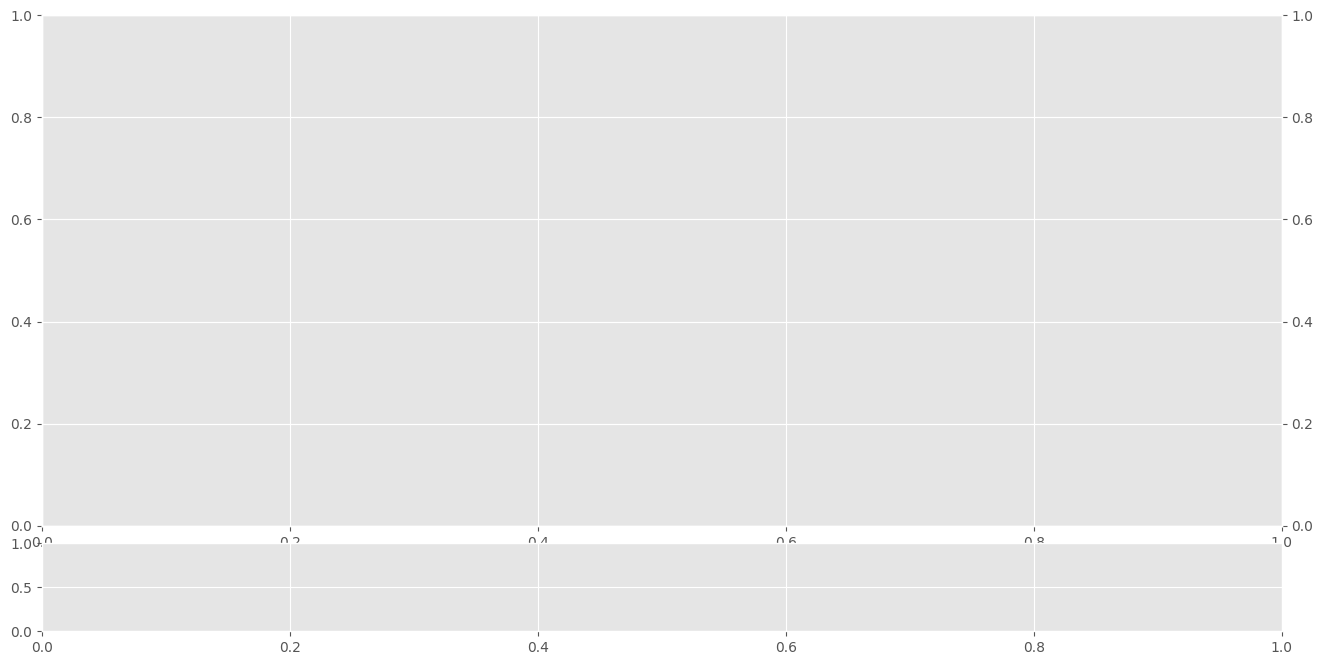

In [102]:
state = train_env.reset(env_steps_size = 500)

In [103]:
states, actions, rewards, dones, next_states, log_prob_olds = [], [], [], [], [], []
for _ in range(500):
    #states.append(np.expand_dims(state, axis=0))
    # Selcet action
    #state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    action, log_prob_old = train_env.act(state, testmode=False) 
    # Observe next state, reward and done signal
    next_state, reward, done = train_env.step(action)
    if done:
        break
    
    #memory.push(state, action, next_state, reward)
    # Store (next_state, action, reward) in the episode minibatch
    states.append(np.expand_dims(state, axis=0))
    next_states.append(np.expand_dims(next_state, axis=0))
    #next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
    actions.append(action)
    rewards.append(reward)
    dones.append(done)
    log_prob_olds.append(log_prob_old)
    
    # Update state
    state = next_state

In [93]:
states.device()

AttributeError: 'list' object has no attribute 'device'

In [75]:
states = torch.from_numpy(np.array(states)).to(torch.float32).to(device)
states.shape

torch.Size([500, 1, 50, 10])

In [131]:
log_prob_olds

[tensor([[-0.2173]]),
 tensor([[-0.0747]]),
 tensor([[-0.5033]]),
 tensor([[-0.8799]]),
 tensor([[0.0507]]),
 tensor([[-0.0860]]),
 tensor([[-0.0822]]),
 tensor([[-1.0333]]),
 tensor([[-0.0175]]),
 tensor([[-0.0020]]),
 tensor([[-0.4157]]),
 tensor([[0.0733]]),
 tensor([[0.0304]]),
 tensor([[-0.0782]]),
 tensor([[0.0698]]),
 tensor([[-0.4075]]),
 tensor([[0.0632]]),
 tensor([[-0.7181]]),
 tensor([[-0.2766]]),
 tensor([[0.0744]]),
 tensor([[-0.3200]]),
 tensor([[-0.2295]]),
 tensor([[-0.2206]]),
 tensor([[-0.5591]]),
 tensor([[-0.0959]]),
 tensor([[-0.1610]]),
 tensor([[-0.9175]]),
 tensor([[0.0075]]),
 tensor([[0.0413]]),
 tensor([[0.0602]]),
 tensor([[-0.4915]]),
 tensor([[0.0313]]),
 tensor([[0.0495]]),
 tensor([[-2.9622]]),
 tensor([[-0.0403]]),
 tensor([[-0.8113]]),
 tensor([[-0.0536]]),
 tensor([[0.0571]]),
 tensor([[-0.6935]]),
 tensor([[-0.5980]]),
 tensor([[0.0637]]),
 tensor([[-0.2705]]),
 tensor([[-0.1047]]),
 tensor([[-0.2627]]),
 tensor([[-0.9896]]),
 tensor([[-1.8295]]),
 

In [98]:
actions = torch.cat(actions,dim=0)

In [100]:
actions.shape

torch.Size([500, 1])

In [104]:
actions

[tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[-1.]]),
 tensor([[

In [105]:
actions = torch.from_numpy(np.array(actions)).to(torch.float32).to(device)

In [128]:
f = [0, 1, 2, 3]

In [129]:
f = torch.tensor(f, dtype = torch.float32)

In [125]:
f = torch.from_numpy(np.array(f)).to(torch.float32).to(device)

In [130]:
f.shape

torch.Size([4])

In [111]:
states = torch.cat(states, dim=0)

TypeError: expected Tensor as element 0 in argument 0, but got numpy.ndarray

In [86]:
train_env.optimize_model(states, actions, rewards, dones, next_states, log_prob_olds)

TypeError: can't convert mps:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:

def train_agent(env, visualize=False, train_episodes=20, training_batch_size=500):
    #memory = Memory(training_batch_size)

    for episode in range(train_episodes):
        state = env.reset(env_steps_size = training_batch_size)
        #state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        
        # Create episode minibatch
        states, actions, rewards, dones, next_states, log_prob_olds = [], [], [], [], [], []
        for _ in range(training_batch_size):
            env.render(visualize)
            #states.append(np.expand_dims(state, axis=0))
            # Selcet action
            #state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            action, log_prob_old = env.act(state, testmode=False) 
            # Observe next state, reward and done signal
            next_state, reward, done = env.step(action)
            if done:
                break
            
            #memory.push(state, action, next_state, reward)
            # Store (next_state, action, reward) in the episode minibatch
            states.append(np.expand_dims(state, axis=0))
            next_states.append(np.expand_dims(next_state, axis=0))
            #next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
            actions.append(action)
            rewards.append(reward)
            dones.append(done)
            log_prob_olds.append(log_prob_old)
            
            # Update state
            state = next_state
        
        # Timestep 내의 모든 state, action, reward, done, next_state 확보했음
        # 확보한 애들을 optimise에 던져줘야 함
        env.optimize_model(states, actions, rewards, dones, next_states, log_prob_olds)
        print(f"Episode {episode} net_worth: {env.net_worth}")
        if episode == train_episodes - 1:
            env.save()